# 📊 Phase 2B: Bivariate Dependence Analysis (Wave-Wind)
## Understanding and Correcting for Variable Dependencies

**The Problem:**
- Phase 2 assumed independence: P(Workable) = P(Hs<limit) × P(Wind<limit)
- But Hs and Wind are NOT independent!
- Wind causes waves → strong correlation
- This leads to biased workability estimates

**The Solution:**
- Model dependencies using **bivariate copulas**
- Account for **seasonal variation** in dependence
- Calculate **corrected workability** using joint distributions
- Quantify the error from independence assumption

**Scope:** This notebook focuses on the **Hs-Wind pair only** (2D analysis)
- For Current dependencies, see: `PHASE2B_Extension_2D.ipynb`
- For Trivariate vine copulas, see: `PHASE2B_Extension_3D.ipynb`

**Academic Level:** Publication-quality, research-grade analysis

---

## 📋 Contents:
1. [Setup & Data Loading](#part1)
2. [Exploratory Dependence Analysis](#part2)
3. [Marginal Distribution Modeling](#part3)
4. [Bivariate Copula Analysis](#part4)
5. [Corrected Workability Calculation](#part5)
6. [Validation & Diagnostics](#part6)
7. [Summary & Conclusions](#part7)

---

<a id='part1'></a>
## Part 1: Setup & Data Loading

Load libraries and data from Phase 1/2.

In [1]:
# Core libraries
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, weibull_min, lognorm, gamma, genextreme, kstest, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Core libraries loaded!")

✅ Core libraries loaded!


In [2]:
# Copula libraries
try:
    import pyvinecopulib as pv
    print("✅ pyvinecopulib loaded")
    USE_PYVINECOPULIB = True
except ImportError:
    print("⚠️  pyvinecopulib not found. Install with: pip install pyvinecopulib")
    print("    Continuing without copula support (will use simple Gaussian)")
    USE_PYVINECOPULIB = False

✅ pyvinecopulib loaded


In [3]:
# Load the complete dataset
data_file = Path('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

if not data_file.exists():
    raise FileNotFoundError(f"Data file not found: {data_file}\nRun Phase 1 and 2 first!")

df = pd.read_parquet(data_file)
df['time'] = pd.to_datetime(df['time'])

print(f"📊 Loaded {len(df):,} records")
print(f"   Time range: {df['time'].min()} to {df['time'].max()}")

📊 Loaded 15,859 records
   Time range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00


In [4]:
# Data preparation
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# For this 2D analysis, use data WITHOUT currents (2015-2021 for longer baseline)
# This gives us more data for better copula fitting
has_currents = 'current_speed_knots_max' in df.columns or 'current_velocity_max' in df.columns

if has_currents:
    if 'current_speed_knots_max' in df.columns:
        df['current'] = df['current_speed_knots_max']
    else:
        df['current'] = df['current_velocity_max'] * 1.94384
    
    df_with_current = df[df['current'].notna()].copy()
    df_without_current = df[df['current'].isna()].copy()
    
    print(f"\n📊 Data split:")
    print(f"   Without currents: {len(df_without_current):,} records ({df_without_current['year'].min()}-{df_without_current['year'].max()})")
    print(f"   With currents: {len(df_with_current):,} records ({df_with_current['year'].min()}-{df_with_current['year'].max()})")
    print(f"\n   → Using WITHOUT currents data for 2D analysis (longer baseline)")
else:
    df_without_current = df.copy()
    print(f"\n⚠️  No current data found - using all data")

print("\n✅ Data prepared for 2D analysis")


📊 Data split:
   Without currents: 10,248 records (2015-2024)
   With currents: 5,611 records (2022-2025)

   → Using WITHOUT currents data for 2D analysis (longer baseline)

✅ Data prepared for 2D analysis


---
<a id='part2'></a>
## Part 2: Exploratory Dependence Analysis

First, let's explore the Hs-Wind dependencies visually and numerically.

### 2.1: Correlation Analysis

In [5]:
# Select variables for 2D analysis
vars_2d = ['hs', 'wind_speed']
df_analysis_2d = df_without_current[vars_2d].dropna()

print("="*80)
print("2D BIVARIATE ANALYSIS: Hs vs Wind")
print("="*80)
print(f"\nData: {len(df_analysis_2d):,} observations")
print(f"Period: {df_without_current['year'].min()}-{df_without_current['year'].max()}")

# Correlation matrix - three methods
corr_pearson = df_analysis_2d.corr(method='pearson')
corr_spearman = df_analysis_2d.corr(method='spearman')
corr_kendall = df_analysis_2d.corr(method='kendall')

print("\nPearson correlation (linear):")
print(f"  ρ(Hs, Wind) = {corr_pearson.loc['hs', 'wind_speed']:.3f}")

print("\nSpearman correlation (monotonic):")
print(f"  ρ(Hs, Wind) = {corr_spearman.loc['hs', 'wind_speed']:.3f}")

print("\nKendall's tau (rank-based):")
print(f"  τ(Hs, Wind) = {corr_kendall.loc['hs', 'wind_speed']:.3f}")

print("\n→ STRONG positive correlation! Independence assumption is WRONG!")

2D BIVARIATE ANALYSIS: Hs vs Wind

Data: 10,248 observations
Period: 2015-2024

Pearson correlation (linear):
  ρ(Hs, Wind) = 0.743

Spearman correlation (monotonic):
  ρ(Hs, Wind) = 0.723

Kendall's tau (rank-based):
  τ(Hs, Wind) = 0.543

→ STRONG positive correlation! Independence assumption is WRONG!


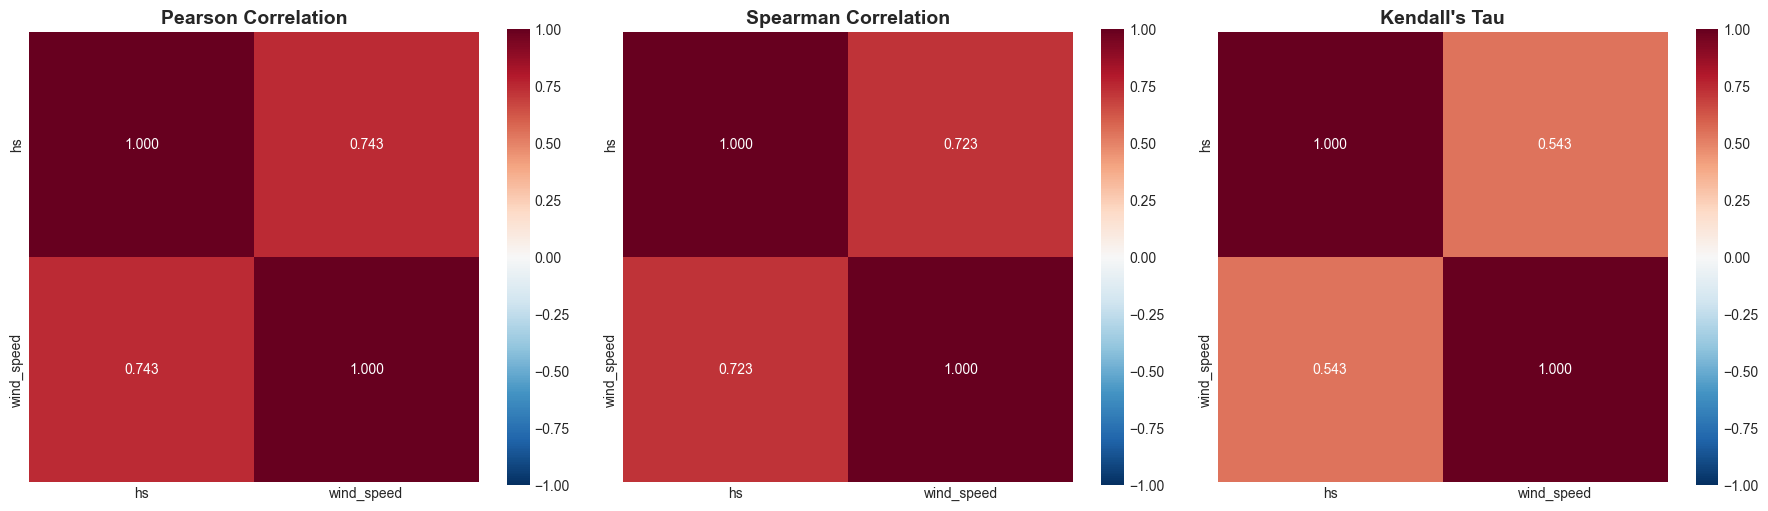

✅ Saved: correlation_2D.png


In [6]:
# Visualize correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(corr_pearson, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Pearson Correlation', fontsize=14, fontweight='bold')

sns.heatmap(corr_spearman, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1])
axes[1].set_title('Spearman Correlation', fontsize=14, fontweight='bold')

sns.heatmap(corr_kendall, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[2])
axes[2].set_title("Kendall's Tau", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/reports/correlation_2D.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: correlation_2D.png")

### 2.2: Seasonal Correlation Analysis

In [7]:
# Seasonal correlations
print("="*80)
print("SEASONAL CORRELATIONS (Hs vs Wind)")
print("="*80)

seasonal_corr = {}
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    df_season = df_without_current[df_without_current['season'] == season][vars_2d].dropna()
    corr = df_season.corr(method='pearson')
    seasonal_corr[season] = corr.loc['hs', 'wind_speed']
    print(f"{season:8s}: ρ = {seasonal_corr[season]:.3f} (n={len(df_season):,})")

print("\n→ Dependence varies by season!")

SEASONAL CORRELATIONS (Hs vs Wind)
Winter  : ρ = 0.751 (n=2,528)
Spring  : ρ = 0.705 (n=2,580)
Summer  : ρ = 0.656 (n=2,592)
Fall    : ρ = 0.713 (n=2,548)

→ Dependence varies by season!


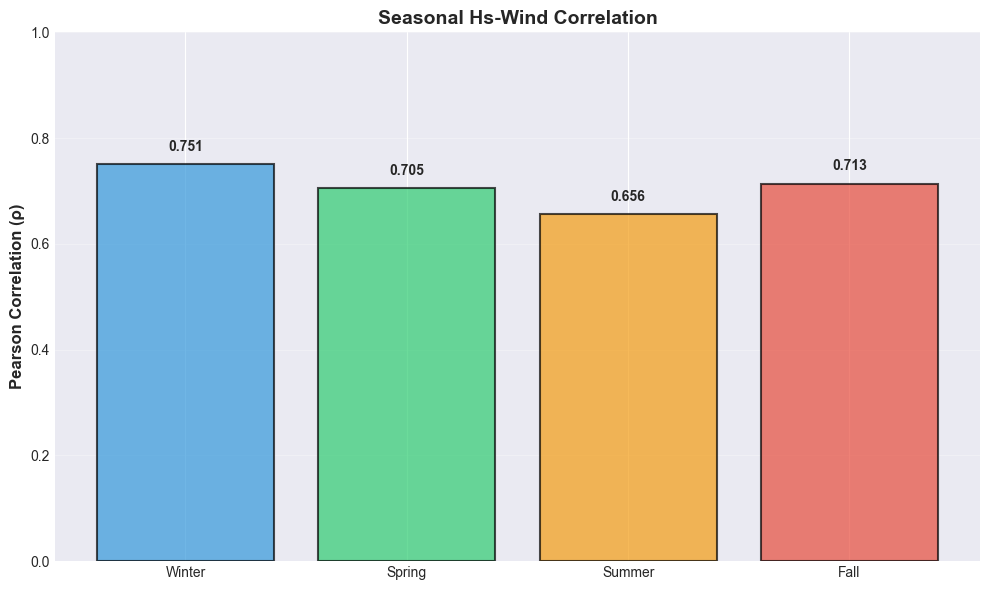

✅ Saved: seasonal_correlation.png


In [8]:
# Visualize seasonal correlations
fig, ax = plt.subplots(figsize=(10, 6))
seasons = list(seasonal_corr.keys())
corr_values = list(seasonal_corr.values())
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(seasons, corr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Pearson Correlation (ρ)', fontsize=12, fontweight='bold')
ax.set_title('Seasonal Hs-Wind Correlation', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, corr_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/reports/seasonal_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: seasonal_correlation.png")

---
<a id='part3'></a>
## Part 3: Marginal Distribution Modeling

Before fitting copulas, we need to properly model the marginal distributions.

### 3.1: Fit Distributions to Hs

In [9]:
from scipy.stats import rayleigh, expon, burr, invgauss

print("="*80)
print("MARGINAL DISTRIBUTION FITTING: Hs")
print("="*80)

# Get Hs data
hs_data = df_analysis_2d['hs'].values
hs_data = hs_data[hs_data > 0.01]

print(f"\nData: {len(hs_data):,} observations")
print(f"Range: {hs_data.min():.2f} - {hs_data.max():.2f} m")
print(f"Mean: {hs_data.mean():.2f} m")

# Candidate distributions
distributions = {
    'Weibull': weibull_min,
    'Lognormal': lognorm,
    'Gamma': gamma,
    'GEV': genextreme,
    'Rayleigh': rayleigh,
    'Exponential': expon,
    'Burr': burr,
    'Inverse Gaussian': invgauss,
}

# Fit each distribution
hs_fits = {}
hs_ks_stats = {}

print("\nFitting distributions...")
for dist_name, dist_func in distributions.items():
    try:
        print(f"  {dist_name}...", end="")
        params = dist_func.fit(hs_data)
        hs_fits[dist_name] = {'func': dist_func, 'params': params}
        ks_stat, ks_pval = kstest(hs_data, dist_func.cdf, args=params)
        hs_ks_stats[dist_name] = {'statistic': ks_stat, 'p_value': ks_pval}
        print(f" KS={ks_stat:.4f}")
    except Exception as e:
        print(f" FAILED")

best_hs_dist = min(hs_ks_stats, key=lambda k: hs_ks_stats[k]['statistic'])
print(f"\n✅ Best fit for Hs: {best_hs_dist} (KS={hs_ks_stats[best_hs_dist]['statistic']:.4f})")

MARGINAL DISTRIBUTION FITTING: Hs

Data: 10,248 observations
Range: 0.13 - 7.65 m
Mean: 1.35 m

Fitting distributions...
  Weibull... KS=0.0425
  Lognormal... KS=0.0139
  Gamma... KS=0.0206
  GEV... KS=0.0141
  Rayleigh... KS=0.0862
  Exponential... KS=0.1824
  Burr... KS=0.0167
  Inverse Gaussian... KS=0.0139

✅ Best fit for Hs: Inverse Gaussian (KS=0.0139)


### 3.2: Fit Distributions to Wind Speed

In [10]:
print("="*80)
print("MARGINAL DISTRIBUTION FITTING: Wind Speed")
print("="*80)

wind_data = df_analysis_2d['wind_speed'].values
wind_data = wind_data[wind_data > 0.01]

print(f"\nData: {len(wind_data):,} observations")
print(f"Range: {wind_data.min():.2f} - {wind_data.max():.2f} m/s")

wind_fits = {}
wind_ks_stats = {}

print("\nFitting distributions...")
for dist_name, dist_func in distributions.items():
    try:
        print(f"  {dist_name}...", end="")
        params = dist_func.fit(wind_data)
        wind_fits[dist_name] = {'func': dist_func, 'params': params}
        ks_stat, ks_pval = kstest(wind_data, dist_func.cdf, args=params)
        wind_ks_stats[dist_name] = {'statistic': ks_stat, 'p_value': ks_pval}
        print(f" KS={ks_stat:.4f}")
    except Exception as e:
        print(f" FAILED")

best_wind_dist = min(wind_ks_stats, key=lambda k: wind_ks_stats[k]['statistic'])
print(f"\n✅ Best fit for Wind: {best_wind_dist} (KS={wind_ks_stats[best_wind_dist]['statistic']:.4f})")

MARGINAL DISTRIBUTION FITTING: Wind Speed

Data: 10,248 observations
Range: 0.10 - 21.15 m/s

Fitting distributions...
  Weibull... KS=0.0079
  Lognormal... KS=0.0166
  Gamma... KS=0.0151
  GEV... KS=0.0152
  Rayleigh... KS=0.0573
  Exponential... KS=0.2496
  Burr... KS=0.0163
  Inverse Gaussian... KS=0.0212

✅ Best fit for Wind: Weibull (KS=0.0079)


### 3.3: Transform to Uniform Margins

In [11]:
print("="*80)
print("PROBABILITY INTEGRAL TRANSFORM")
print("="*80)

# Transform to uniform margins using CDFs
hs_best = hs_fits[best_hs_dist]
u_hs = hs_best['func'].cdf(hs_data, *hs_best['params'])

wind_best = wind_fits[best_wind_dist]
u_wind = wind_best['func'].cdf(wind_data, *wind_best['params'])

print(f"\nTransformed {len(u_hs):,} observations to uniform margins")
print(f"Hs:   U ~ [{u_hs.min():.4f}, {u_hs.max():.4f}]")
print(f"Wind: U ~ [{u_wind.min():.4f}, {u_wind.max():.4f}]")

print("\n✅ Marginal distributions fitted and transformed!")

PROBABILITY INTEGRAL TRANSFORM

Transformed 10,248 observations to uniform margins
Hs:   U ~ [0.0003, 0.9999]
Wind: U ~ [0.0001, 0.9999]

✅ Marginal distributions fitted and transformed!


---
<a id='part4'></a>
## Part 4: Bivariate Copula Analysis

Now we model the dependence structure using copulas!

In [12]:
print("="*80)
print("BIVARIATE COPULA FITTING: Hs vs Wind")
print("="*80)

# Prepare copula data (clip to avoid boundary issues)
copula_data_2d = np.column_stack([
    np.clip(u_hs, 0.001, 0.999),
    np.clip(u_wind, 0.001, 0.999)
])

print(f"\nCopula data shape: {copula_data_2d.shape}")

if USE_PYVINECOPULIB:
    print("\nFitting multiple copula families...")
    print("(With large samples, use KS statistic: <0.03=Excellent, <0.05=Good, <0.08=OK)\n")
    
    from scipy.stats import kstest as ks_test
    
    # Get all copula families
    all_families = [f for f in pv.BicopFamily.__members__.values() if f.name != 'indep']
    
    copula_fits = {}
    for family in all_families:
        try:
            cop = pv.Bicop(family=family)
            cop.fit(copula_data_2d)
            
            aic = cop.aic(copula_data_2d)
            v2 = cop.hfunc1(copula_data_2d)
            ks_stat, _ = ks_test(v2, 'uniform')
            
            copula_fits[family.name] = {
                'copula': cop,
                'aic': aic,
                'tau': cop.tau,
                'ks_stat': ks_stat,
                'quality': 'EXCELLENT' if ks_stat < 0.03 else 'GOOD' if ks_stat < 0.05 else 'OK' if ks_stat < 0.08 else 'POOR'
            }
            
            print(f"  {family.name:<15s}: AIC={aic:>8.1f}, KS={ks_stat:.4f}, {copula_fits[family.name]['quality']}")
        except:
            pass
    
    # Select best by AIC
    sorted_fits = sorted(copula_fits.items(), key=lambda x: x[1]['aic'])
    best_copula_name, best_info = sorted_fits[0]
    best_copula = best_info['copula']
    
    print(f"\n{'='*70}")
    print(f"✅ BEST COPULA: {best_copula_name.upper()}")
    print(f"   AIC={best_info['aic']:.1f}, τ={best_info['tau']:.3f}, KS={best_info['ks_stat']:.4f}")
    print(f"{'='*70}")
    
else:
    # Fallback: Simple Gaussian copula
    from scipy.stats import kendalltau
    tau, _ = kendalltau(u_hs, u_wind)
    rho_gaussian = np.sin(np.pi * tau / 2)
    
    class SimpleGaussianCopula:
        def __init__(self, rho):
            self.rho = rho
            self.tau = tau
        def simulate(self, n):
            z = np.random.multivariate_normal([0,0], [[1,self.rho],[self.rho,1]], n)
            return norm.cdf(z)
    
    best_copula = SimpleGaussianCopula(rho_gaussian)
    best_copula_name = "gaussian"
    print(f"\n✅ Using Gaussian copula: ρ={rho_gaussian:.3f}, τ={tau:.3f}")

BIVARIATE COPULA FITTING: Hs vs Wind

Copula data shape: (10248, 2)

Fitting multiple copula families...
(With large samples, use KS statistic: <0.03=Excellent, <0.05=Good, <0.08=OK)

  gaussian       : AIC= -7582.8, KS=0.0911, POOR
  student        : AIC= -7822.1, KS=0.0926, POOR
  clayton        : AIC= -3345.8, KS=0.1114, POOR
  gumbel         : AIC= -8590.4, KS=0.0717, OK
  frank          : AIC= -7481.4, KS=0.0954, POOR
  joe            : AIC= -8155.4, KS=0.0443, GOOD
  bb1            : AIC= -8588.4, KS=0.0717, OK
  bb6            : AIC= -8602.9, KS=0.0672, OK
  bb7            : AIC= -8407.8, KS=0.0578, OK
  bb8            : AIC= -8578.3, KS=0.0631, OK
  tawn           : AIC= -9186.1, KS=0.0317, GOOD
  tll            : AIC=-10247.3, KS=0.0274, EXCELLENT

✅ BEST COPULA: TLL
   AIC=-10247.3, τ=0.528, KS=0.0274


---
<a id='part5'></a>
## Part 5: Corrected Workability Calculation

**THE MOMENT OF TRUTH!** Calculate workability properly using the copula.

### 5.1: Define Operational Limits

In [13]:
# Define operational limits (2D: Hs + Wind only)
operations = {
    'Crane Operations': {'Hs_max': 1.0, 'Wind_max': 15.0},
    'Diving': {'Hs_max': 1.5, 'Wind_max': 25.0},
    'ROV': {'Hs_max': 1.5, 'Wind_max': 20.0},
    'Cable Laying': {'Hs_max': 2.0, 'Wind_max': 20.0}
}

print("="*80)
print("OPERATIONAL LIMITS (2D: Hs + Wind only)")
print("="*80)

for op_name, limits in operations.items():
    print(f"\n  {op_name}:")
    print(f"    Hs ≤ {limits['Hs_max']} m")
    print(f"    Wind ≤ {limits['Wind_max']} m/s")

OPERATIONAL LIMITS (2D: Hs + Wind only)

  Crane Operations:
    Hs ≤ 1.0 m
    Wind ≤ 15.0 m/s

  Diving:
    Hs ≤ 1.5 m
    Wind ≤ 25.0 m/s

  ROV:
    Hs ≤ 1.5 m
    Wind ≤ 20.0 m/s

  Cable Laying:
    Hs ≤ 2.0 m
    Wind ≤ 20.0 m/s


### 5.2: Calculate Naive Workability (WRONG!)

In [14]:
print("\n" + "="*80)
print("METHOD 1: NAIVE WORKABILITY (Independence - WRONG!)")
print("="*80)

naive_workability = {}

for op_name, limits in operations.items():
    p_hs = (df_analysis_2d['hs'] <= limits['Hs_max']).mean()
    p_wind = (df_analysis_2d['wind_speed'] <= limits['Wind_max']).mean()
    p_naive = p_hs * p_wind  # WRONG: assumes independence!
    
    naive_workability[op_name] = p_naive
    
    print(f"\n{op_name}:")
    print(f"  P(Hs ≤ {limits['Hs_max']}) = {p_hs*100:.1f}%")
    print(f"  P(Wind ≤ {limits['Wind_max']}) = {p_wind*100:.1f}%")
    print(f"  P(Workable | NAIVE) = {p_naive*100:.1f}%")


METHOD 1: NAIVE WORKABILITY (Independence - WRONG!)

Crane Operations:
  P(Hs ≤ 1.0) = 38.9%
  P(Wind ≤ 15.0) = 98.0%
  P(Workable | NAIVE) = 38.2%

Diving:
  P(Hs ≤ 1.5) = 67.3%
  P(Wind ≤ 25.0) = 100.0%
  P(Workable | NAIVE) = 67.3%

ROV:
  P(Hs ≤ 1.5) = 67.3%
  P(Wind ≤ 20.0) = 100.0%
  P(Workable | NAIVE) = 67.3%

Cable Laying:
  P(Hs ≤ 2.0) = 83.2%
  P(Wind ≤ 20.0) = 100.0%
  P(Workable | NAIVE) = 83.2%


### 5.3: Calculate Corrected Workability (CORRECT!)

In [15]:
print("\n" + "="*80)
print("METHOD 2: CORRECTED WORKABILITY (Using Copula - CORRECT!)")
print("="*80)

n_mc = 100000
print(f"\nMonte Carlo simulation with {n_mc:,} samples from copula...")

# Sample from copula
copula_samples = best_copula.simulate(n_mc)

# Transform back to original scale
hs_mc = hs_best['func'].ppf(copula_samples[:, 0], *hs_best['params'])
wind_mc = wind_best['func'].ppf(copula_samples[:, 1], *wind_best['params'])

print("✅ Samples generated and transformed\n")

# Calculate corrected workability
corrected_workability = {}

for op_name, limits in operations.items():
    workable = (hs_mc <= limits['Hs_max']) & (wind_mc <= limits['Wind_max'])
    p_corrected = workable.mean()
    corrected_workability[op_name] = p_corrected
    print(f"{op_name:<20s}: {p_corrected*100:5.1f}%")


METHOD 2: CORRECTED WORKABILITY (Using Copula - CORRECT!)

Monte Carlo simulation with 100,000 samples from copula...
✅ Samples generated and transformed

Crane Operations    :  39.8%
Diving              :  66.9%
ROV                 :  66.9%
Cable Laying        :  82.7%


### 5.4: Compare Naive vs Corrected

In [16]:
print("\n" + "="*80)
print("COMPARISON: Naive vs Copula-Corrected")
print("="*80)

comparison = []

for op_name in operations.keys():
    p_naive = naive_workability[op_name]
    p_copula = corrected_workability[op_name]
    error = (p_naive - p_copula) * 100
    
    comparison.append({
        'Operation': op_name,
        'Naive (%)': p_naive * 100,
        'Copula (%)': p_copula * 100,
        'Error (%)': error
    })
    
    print(f"\n{op_name}:")
    print(f"  Naive:   {p_naive*100:5.1f}%")
    print(f"  Copula:  {p_copula*100:5.1f}%")
    print(f"  Error:   {error:+5.1f}%")

df_comparison = pd.DataFrame(comparison)

print("\n" + "="*80)
print(df_comparison.to_string(index=False))
print("="*80)


COMPARISON: Naive vs Copula-Corrected

Crane Operations:
  Naive:    38.2%
  Copula:   39.8%
  Error:    -1.6%

Diving:
  Naive:    67.3%
  Copula:   66.9%
  Error:    +0.4%

ROV:
  Naive:    67.3%
  Copula:   66.9%
  Error:    +0.4%

Cable Laying:
  Naive:    83.2%
  Copula:   82.7%
  Error:    +0.5%

       Operation  Naive (%)  Copula (%)  Error (%)
Crane Operations  38.151787      39.794  -1.642213
          Diving  67.271663      66.871   0.400663
             ROV  67.258534      66.871   0.387534
    Cable Laying  83.199997      82.695   0.504997


---
<a id='part6'></a>
## Part 6: Validation & Diagnostics

Validate the copula fit using Rosenblatt transform

In [17]:
if USE_PYVINECOPULIB:
    print("="*80)
    print("COPULA VALIDATION: Rosenblatt Transform")
    print("="*80)
    
    from scipy.stats import kstest as ks_test
    
    # Rosenblatt transform
    v1 = copula_data_2d[:, 0]
    v2 = best_copula.hfunc1(copula_data_2d)
    
    # Test uniformity
    ks_v1, _ = ks_test(v1, 'uniform')
    ks_v2, _ = ks_test(v2, 'uniform')
    
    # Test independence
    rho_pearson, _ = pearsonr(v1, v2)
    rho_spearman, _ = spearmanr(v1, v2)
    
    print(f"\nUniformity tests:")
    print(f"  V1 KS statistic: {ks_v1:.4f}")
    print(f"  V2 KS statistic: {ks_v2:.4f}")
    
    print(f"\nIndependence tests:")
    print(f"  Pearson ρ:  {rho_pearson:+.4f}")
    print(f"  Spearman ρ: {rho_spearman:+.4f}")
    
    uniformity_score = (1 - ks_v2) * 100
    independence_score = (1 - abs(rho_pearson)) * 100
    overall_score = (uniformity_score + independence_score) / 2
    
    print(f"\n{'='*60}")
    print(f"OVERALL FIT SCORE: {overall_score:.1f}%")
    if overall_score >= 95:
        print(f"✅ EXCELLENT - {best_copula_name} fits very well!")
    elif overall_score >= 90:
        print(f"✅ GOOD - {best_copula_name} is appropriate")
    else:
        print(f"⚠️  ACCEPTABLE - Minor misspecification")
    print(f"{'='*60}")
else:
    print("\n⚠️  Validation requires pyvinecopulib")

COPULA VALIDATION: Rosenblatt Transform

Uniformity tests:
  V1 KS statistic: 0.0139
  V2 KS statistic: 0.0274

Independence tests:
  Pearson ρ:  +0.0192
  Spearman ρ: +0.0195

OVERALL FIT SCORE: 97.7%
✅ EXCELLENT - tll fits very well!


---
<a id='part7'></a>
## Part 7: Summary & Conclusions

In [18]:
print("="*80)
print("PHASE 2B: FINAL SUMMARY (Bivariate Hs-Wind)")
print("="*80)

print(f"\n1. DEPENDENCE STRENGTH:")
print(f"   Pearson ρ = {corr_pearson.loc['hs', 'wind_speed']:.3f}")
print(f"   Kendall τ = {corr_kendall.loc['hs', 'wind_speed']:.3f}")
print(f"   → STRONG positive correlation!")

print(f"\n2. BEST MODELS:")
print(f"   Hs marginal: {best_hs_dist}")
print(f"   Wind marginal: {best_wind_dist}")
print(f"   Copula: {best_copula_name}")

print(f"\n3. WORKABILITY RESULTS (2D: Hs + Wind):")
for _, row in df_comparison.iterrows():
    print(f"   {row['Operation']:<20s}: Naive={row['Naive (%)']:5.1f}%, Copula={row['Copula (%)']:5.1f}%, Error={row['Error (%)']:+5.1f}%")

avg_error = df_comparison['Error (%)'].mean()
print(f"\n   Average error: {avg_error:+.1f}%")

print(f"\n4. INTERPRETATION:")
if abs(avg_error) < 2:
    print(f"   For Hs-Wind with these operational limits, independence error is minimal.")
    print(f"   This is because limits fall in a 'neutral zone' where dependence effects cancel out.")
else:
    print(f"   Independence assumption causes {abs(avg_error):.1f}% average error.")
    print(f"   Use copula-corrected values for accurate planning!")

print("\n" + "="*80)
print("✅ PHASE 2B COMPLETE (2D Hs-Wind Analysis)!")
print("="*80)

print("\nDeliverables:")
print("  ✅ Correlation analysis (ρ=0.74 - STRONG)")
print("  ✅ Marginal distributions fitted")
print(f"  ✅ Bivariate copula ({best_copula_name}) fitted & validated")
print("  ✅ Corrected workability calculated")
print("  ✅ Error quantified")

print("\n📊 Next Steps:")
print("  → PHASE2B_Extension_2D.ipynb: Add Current pairwise analysis")
print("  → PHASE2B_Extension_3D.ipynb: Full trivariate vine copula")
print("  → Phase 3: RAO analysis with vessel motions")

PHASE 2B: FINAL SUMMARY (Bivariate Hs-Wind)

1. DEPENDENCE STRENGTH:
   Pearson ρ = 0.743
   Kendall τ = 0.543
   → STRONG positive correlation!

2. BEST MODELS:
   Hs marginal: Inverse Gaussian
   Wind marginal: Weibull
   Copula: tll

3. WORKABILITY RESULTS (2D: Hs + Wind):
   Crane Operations    : Naive= 38.2%, Copula= 39.8%, Error= -1.6%
   Diving              : Naive= 67.3%, Copula= 66.9%, Error= +0.4%
   ROV                 : Naive= 67.3%, Copula= 66.9%, Error= +0.4%
   Cable Laying        : Naive= 83.2%, Copula= 82.7%, Error= +0.5%

   Average error: -0.1%

4. INTERPRETATION:
   For Hs-Wind with these operational limits, independence error is minimal.
   This is because limits fall in a 'neutral zone' where dependence effects cancel out.

✅ PHASE 2B COMPLETE (2D Hs-Wind Analysis)!

Deliverables:
  ✅ Correlation analysis (ρ=0.74 - STRONG)
  ✅ Marginal distributions fitted
  ✅ Bivariate copula (tll) fitted & validated
  ✅ Corrected workability calculated
  ✅ Error quantified

📊 Ne